In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/sample_submission.csv.7z


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline
# notebook

#Take a look at a iceberg
# plotly -
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

py.init_notebook_mode(connected=True) 
# plotly 를 jupyter notebook

In [3]:
!pip install py7zr
import py7zr
import os

if not os.path.exists('/kaggle/train/') :
    os.makedirs('/kaggle/train/')

if not os.path.exists('/kaggle/test/') :
    os.makedirs('/kaggle/test/')

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/train")

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/test")

for dirname, _, filenames in os.walk('/kaggle'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 497.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.2/384.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/test/data/processed/test.json
/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/sample_submission.csv.7z
/kaggle/train/data/processed/train.json
/kaggle/working/__notebook__.ipynb


In [4]:
train = pd.read_json('/kaggle/train/data/processed/train.json')
test = pd.read_json('/kaggle/test/data/processed/test.json')

In [5]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [6]:
train['inc_angle'].value_counts()

na         133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
44.0359      1
45.1289      1
43.9369      1
39.6857      1
37.9814      1
Name: inc_angle, Length: 879, dtype: int64

In [7]:
train.inc_angle = train.inc_angle.replace('na',0)
train['inc_angle'].value_counts()

0.0000     133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
44.0359      1
45.1289      1
43.9369      1
39.6857      1
37.9814      1
Name: inc_angle, Length: 879, dtype: int64

In [8]:
# reshape(75 ,75)=> 
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#np.concatenate
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
#np.nexaxis = None, indexing

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)



In [9]:
def plot_contour_2d(band1, band2, label):
    fig = tools.make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
    fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r',
                          scene='scene1', showscale=False), 1, 1)
    fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 2)
    
    fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=800, width=1200)

    py.iplot(fig)
    

    fig, ax = plt.subplots(1,2,figsize=(16,10))
    ax[0].imshow(X_band_1[num,:,:])
    ax[0].set_title('Image from band_1', fontsize=15)
    ax[1].imshow(X_band_2[num,:,:])
    ax[1].set_title('Image from band_2', fontsize=15)
    plt.show()

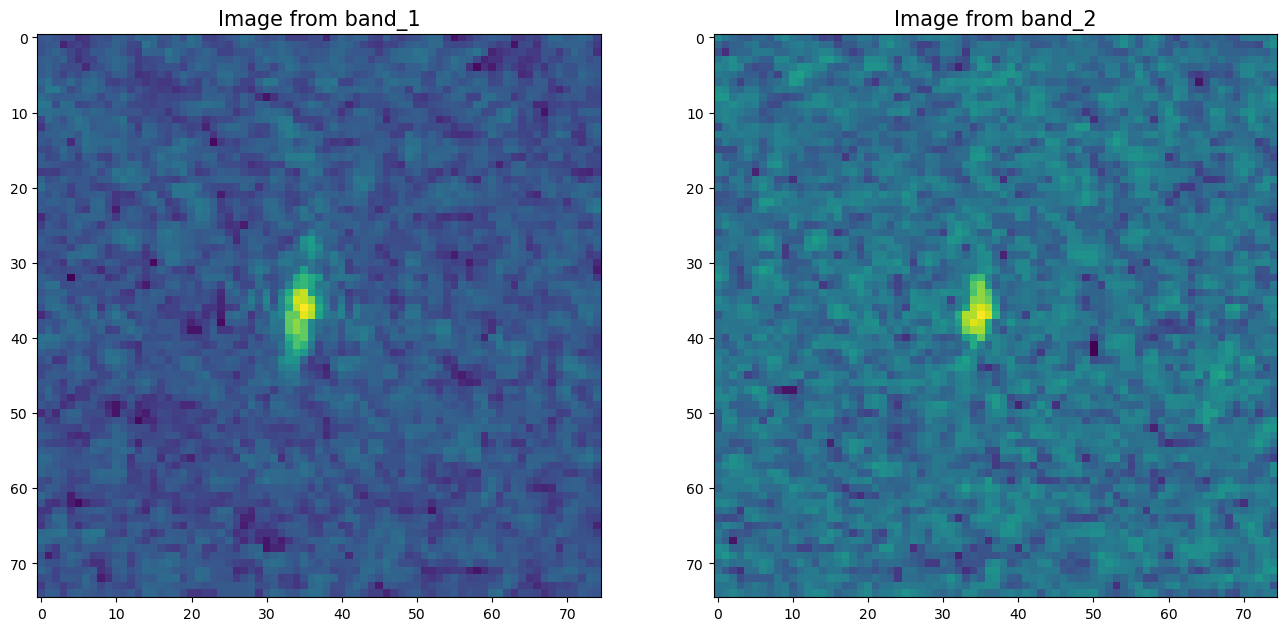

In [10]:
num = 0
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

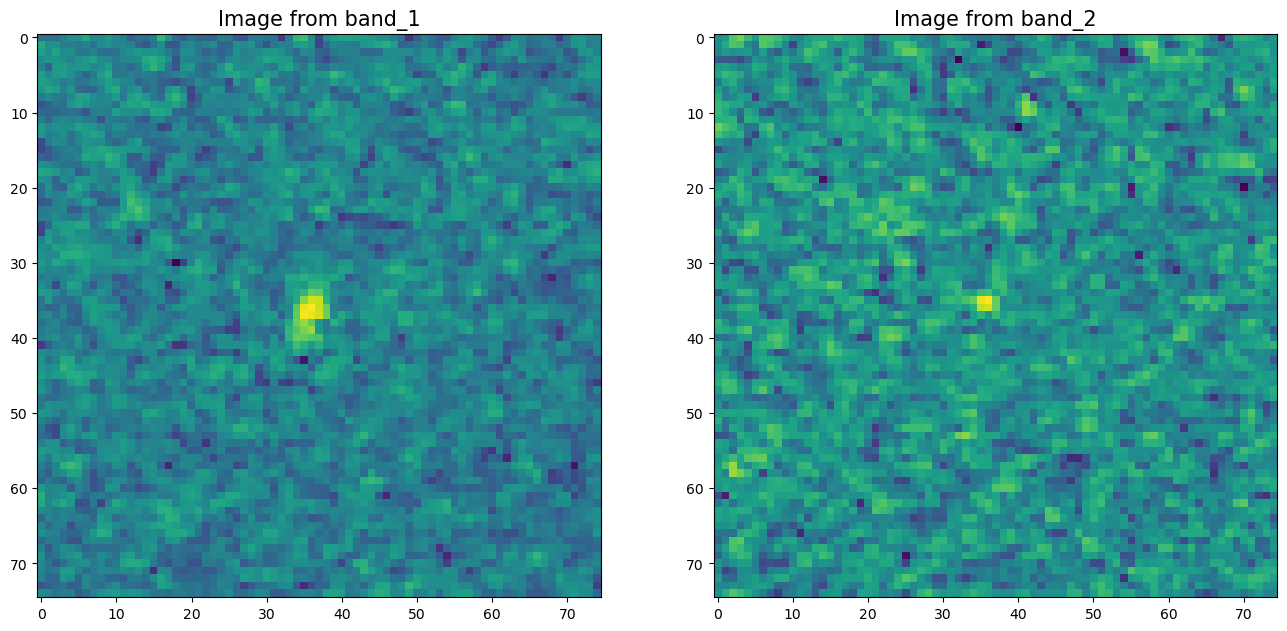

In [11]:
num = 2
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

In [12]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [13]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # input size
    gmodel.add(Dropout(0.2))
    # overfitting

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    #Adam  
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                   optimizer=mypotim,
                   metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [14]:
target_train = train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      target_train,
                                                      random_state=1,
                                                      train_size = 0.8)
# train_test_splil train set train, vaild

gmodel=getModel()
gmodel.fit(X_train, y_train,
          batch_size=24,
          epochs=10,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

In [15]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 1s 60ms/step - loss: 0.3782 - accuracy: 0.8474
Test loss: 0.3782326281070709
Test accuracy: 0.8473520278930664


In [16]:
#predicted_test = gmodel.predict_proba(X_test)
predict_prob=gmodel.predict([X_test])

#predict_classes=np.argmax(predict_prob,axis=1)

264/264 [==============================] - 19s 70ms/step


In [17]:
predict_classes

NameError: name 'predict_classes' is not defined

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predict_classes.reshape((predict_classes.shape[0]))
submission.to_csv('sub.csv', index=False)

In [ ]:
submission.head(100)